# Data Cleaning

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import seaborn as sns
from scipy.stats import mode
from functools import reduce
from pykalman import KalmanFilter
import pmdarima as pm

In [2]:
DGS1 = pd.read_excel("DATA/DGS1.xls", skiprows=10)
DGS2 = pd.read_excel("DATA/DGS2.xls", skiprows=10)
DGS3MO   = pd.read_excel("DATA/DGS3MO.xls", skiprows=10)
DGS6MO  = pd.read_excel("DATA/DGS6MO.xls", skiprows=10)
DGS10= pd.read_excel("DATA/DGS10.xls", skiprows=10)
DGS3 = pd.read_excel("DATA/DGS3.xls", skiprows=10)
DGS5= pd.read_excel("DATA/DGS5.xls", skiprows=10)
DGS7= pd.read_excel("DATA/DGS7.xls", skiprows=10)

#Drop the 0 columns
DGS1 = DGS1[(DGS1 != 0.00).all(axis=1)]
DGS2 = DGS2[(DGS2 != 0.00).all(axis=1)]
DGS3MO = DGS3MO[(DGS3MO != 0.00).all(axis=1)]
DGS6MO = DGS6MO[(DGS6MO != 0.00).all(axis=1)]
DGS10 = DGS10[(DGS10 != 0.00).all(axis=1)]
DGS3 = DGS3[(DGS3 != 0.00).all(axis=1)]
DGS5 = DGS5[(DGS5 != 0.00).all(axis=1)]
DGS7 = DGS7[(DGS7 != 0.00).all(axis=1)]

In [3]:
index_comparison = {
    'DGS2': set(DGS1.index) == set(DGS2.index),
    'DGS3MO': set(DGS1.index) == set(DGS3MO.index),
    'DGS6MO': set(DGS1.index) == set(DGS6MO.index),
    'DGS10': set(DGS1.index) == set(DGS10.index),
    'DGS3': set(DGS1.index) == set(DGS3.index),
    'DGS5': set(DGS1.index) == set(DGS5.index),
    'DGS7': set(DGS1.index) == set(DGS7.index),
}

for df_name, comparison_result in index_comparison.items():
    print(f"{df_name} has the same indices as DGS1: {comparison_result}")


DGS2 has the same indices as DGS1: True
DGS3MO has the same indices as DGS1: False
DGS6MO has the same indices as DGS1: True
DGS10 has the same indices as DGS1: True
DGS3 has the same indices as DGS1: True
DGS5 has the same indices as DGS1: True
DGS7 has the same indices as DGS1: True


In [14]:
# Assume df1, df2, df3, ... are DataFrame objects you want to merge
dataframes = [DGS3MO, DGS1, DGS2, DGS6MO, DGS10, DGS3, DGS5, DGS7]

# Using reduce to merge multiple DataFrames on a common key
merged_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date'), dataframes)

In [15]:
merged_df

,observation_date,DGS3MO,DGS1,DGS2,DGS6MO,DGS10,DGS3,DGS5,DGS7
0,2014-01-02,0.07,0.13,0.39,0.09,3.00,0.76,1.72,2.41
1,2014-01-03,0.07,0.13,0.41,0.10,3.01,0.80,1.73,2.42
2,2014-01-06,0.05,0.12,0.40,0.08,2.98,0.78,1.70,2.38
3,2014-01-07,0.04,0.13,0.40,0.08,2.96,0.80,1.69,2.37
4,2014-01-08,0.05,0.13,0.43,0.08,3.01,0.87,1.77,2.44
...,...,...,...,...,...,...,...,...,...
2517,2024-02-13,5.45,4.99,4.64,5.32,4.31,4.44,4.31,4.33
2518,2024-02-14,5.43,4.94,4.56,5.31,4.27,4.38,4.25,4.27
2519,2024-02-15,5.43,4.93,4.56,5.30,4.24,4.36,4.22,4.25
2520,2024-02-16,5.44,4.98,4.64,5.31,4.30,4.43,4.29,4.31


In [16]:
time_period = merged_df.iloc[:,0].values

# Task B

Formulating Curve Fitting Problem

In [17]:


# Assuming `merged_df` is your DataFrame

# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

# Initialize a dictionary to hold the results
results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(NS_model, x_data, y_data,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    results[row] = {
        'Parameters': params,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
for column, metrics in results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
print(params)


0:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.87913573 -1.16230179 -3.74444308  1.27768612]
  MAE: 0.5707403738897879
  MSE: 0.569329222991669
  R2: 0.5126381813754123

1:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.89697779 -1.19581638 -3.72807745  1.27439072]
  MAE: 0.5677719237721739
  MSE: 0.5616923751678782
  R2: 0.5195713759247287

2:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-1.42191765e+03  1.42218988e+03 -1.30967475e+04 -1.51204297e-05]
  MAE: 0.5122858010288165
  MSE: 0.6398861255181036
  R2: 0.44457267433555037

3:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-7.13105071e+02  7.13377130e+02 -2.64681650e+04 -8.05303478e-06]
  MAE: 0.5078106223174963
  MSE: 0.6273553520666648
  R2: 0.4479867006126814

4:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.9363088  -1.3001542  -3.67961583  1.2377161 ]
  MAE: 0.5636829910948935
  MSE: 0.5507702770972008
  R2: 0.5351242366097174

5:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 1.91314194 -1.32462569 -3.55976361  1.221682

In [18]:
lambdas = [value['Parameters'][3] for value in results.values()]
beta_0 = [value['Parameters'][0] for value in results.values()]
beta_1 = [value['Parameters'][1] for value in results.values()]
beta_2 = [value['Parameters'][2] for value in results.values()]
#sns.distplot(lambdas, bins=1000)

In [19]:
np.median(lambdas), mode(lambdas)[0],np.nanmean([_ if _>0 else np.nan for _ in lambdas])

/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_3802/881844047.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  np.median(lambdas), mode(lambdas)[0],np.nanmean([_ if _>0 else np.nan for _ in lambdas])


(0.478295155267787, array([1.00213091]), 1.397628138375958)

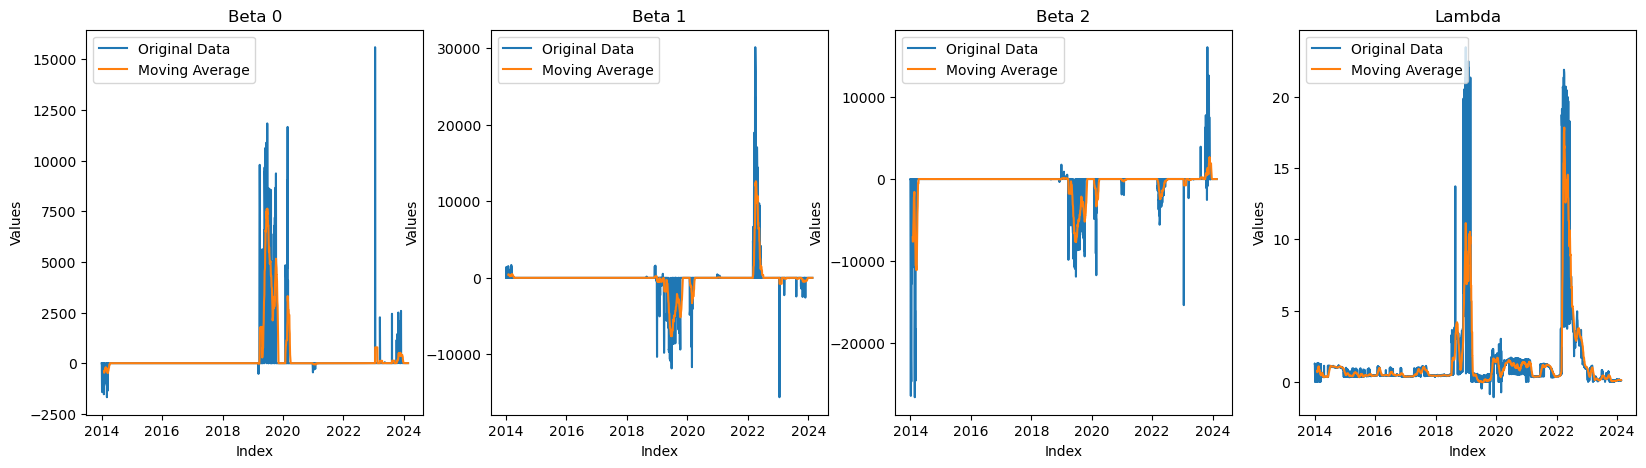

In [20]:
def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot, index=time_period)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    plt.subplot(1, 4, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(beta_0, 1, 'Beta 0')
plotting_param(beta_1, 2, 'Beta 1')
plotting_param(beta_2, 3, 'Beta 2')  # Assuming you have beta_3
plotting_param(lambdas, 4, 'Lambda')  # Assuming you have beta_4
plt.show()


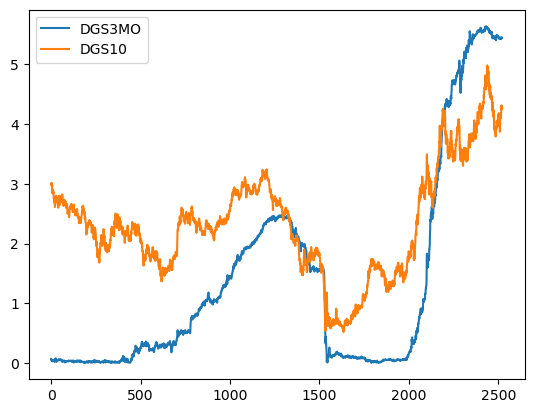

In [21]:
#merged_df.set_index('observation_date', inplace=True)
merged_df["DGS3MO"].plot()
#merged_df["DGS6MO"].plot()
#merged_df["DGS1"].plot()
#merged_df["DGS2"].plot()
#merged_df["DGS3"].plot()
#merged_df["DGS5"].plot()
#merged_df["DGS7"].plot()
merged_df["DGS10"].plot()
plt.legend()

Finding the optimal lambda with  time-series-crossvalidation

1. What is our loss function
2. How do we cross validate in time series
3. compare cross-validation against vanilla method


In [41]:
rounded_lambdas =  [round(num, 2) for num in lambdas]
len(set(rounded_lambdas))

415

In [42]:
set(rounded_lambdas)

{-1.08,
 -0.86,
 -0.74,
 -0.47,
 -0.42,
 -0.0,
 0.01,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0,
 1.01,
 1.02,
 1.03,
 1.04,
 1.05,
 1.06,
 1.07,
 1.08,
 1.09,
 1.1,
 1.11,
 1.12,
 1.13,
 1.14,
 1.15,
 1.16,
 1.17,
 1.18,
 1.19,
 1.2,
 1.21,
 1.22,
 1.23,
 1.24,
 1.25,
 1.26,
 1.27,
 1.28,
 1.29,
 1.3,
 1.31,
 1.32,
 1.33,
 1.34,
 1.35,
 1.37,
 1.38,
 1.39,
 1.4,
 1.41,
 

In [ ]:

# Assuming NS_model is defined elsewhere
# Assuming results, merged_df, and rounded_lambdas are defined elsewhere

# Initialize a dictionary to hold the results
op_lam = {}
lambda_range = set(rounded_lambdas)
min_mse = float('inf')  # Using float('inf') is a more conventional way to initialize to infinity
min_mae = float('inf')
min_r2 = float('inf')

for lambda_opt in tqdm(lambda_range, desc="Optimizing Lambda"):
    mae = 0
    mse = 0
    r2 = 0
    for row in range(len(merged_df)):  # Assuming merged_df is defined elsewhere
        y_data = merged_df.iloc[row].values[1:]
        x_data = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])
        
        # Apply curve fit and predict (assuming NS_model and results are correctly defined)
        y_pred = NS_model(x_data, results[row]['Parameters'][0], results[row]['Parameters'][1], results[row]['Parameters'][2], lambda_opt)
        
        # Calculate metrics
        mae += mean_absolute_error(y_data, y_pred)
        mse += mean_squared_error(y_data, y_pred)
        r2 += r2_score(y_data, y_pred)

    # Update minimum metrics and corresponding lambda
    if mse < min_mse:
        op_lam["mse"] = lambda_opt
        min_mse = mse
    if mae < min_mae:
        op_lam["mae"] = lambda_opt
        min_mae = mae
    if r2 < min_r2:
        op_lam["r2"] = lambda_opt
        min_r2 = r2

print(op_lam)


In [ ]:
op_lam

In [43]:
op_lam_1 = 0.4

In [44]:
op_lam_2 = 0.37

Part B (ii) and (iii): Optimal Parameter Fitting for beta_0, beta_1 and beta_2

In [45]:


# Assuming `merged_df` is your DataFrame

# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

def NS_model_lambda_fixed(s, beta_0,beta_1,beta_2):
    return beta_0 + beta_1 * np.exp(-op_lam_2*s) + beta_2*op_lam_2*s*np.exp(-op_lam_2*s)

# Initialize a dictionary to hold the results
fix_lambda_results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(NS_model_lambda_fixed, x_data, y_data,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model_lambda_fixed(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    fix_lambda_results[row] = {
        'Parameters': params,
        'lambda': -1.08,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
for column, metrics in fix_lambda_results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  lambda: {metrics['lambda']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
print(params)


0:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.1032531  -2.34834445 -0.02433051]
  lambda: -1.08
  MAE: 0.5390655457061901
  MSE: 0.5916226124823453
  R2: 0.4935544133081595

1:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.11251235 -2.36315448  0.01910728]
  lambda: -1.08
  MAE: 0.535926585133967
  MSE: 0.5840213619718212
  R2: 0.5004728713313434

2:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.07295705 -2.33832827  0.04684137]
  lambda: -1.08
  MAE: 0.5314806968249067
  MSE: 0.5783379256092492
  R2: 0.4979971052015213

3:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.06554838 -2.33342747  0.05921036]
  lambda: -1.08
  MAE: 0.5238113700346656
  MSE: 0.5647922906407425
  R2: 0.5030362699575923

4:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.15434583 -2.42070126  0.00601842]
  lambda: -1.08
  MAE: 0.5245363362968886
  MSE: 0.5712055614300511
  R2: 0.5178759049560928

5:
  Parameters (beta_0,beta_1,beta_2, lmbda): [ 2.13086838 -2.39331054 -0.00961409]
  lambda: -1.08
  MAE

In [47]:

#lambdas = [value['Parameters'][3] for value in results.values()]
fix_lambda_beta_0 = [value['Parameters'][0] for value in fix_lambda_results.values()]
fix_lambda_beta_1 = [value['Parameters'][1] for value in fix_lambda_results.values()]
fix_lambda_beta_2 = [value['Parameters'][2] for value in fix_lambda_results.values()]
#sns.distplot(lambdas, bins=1000)

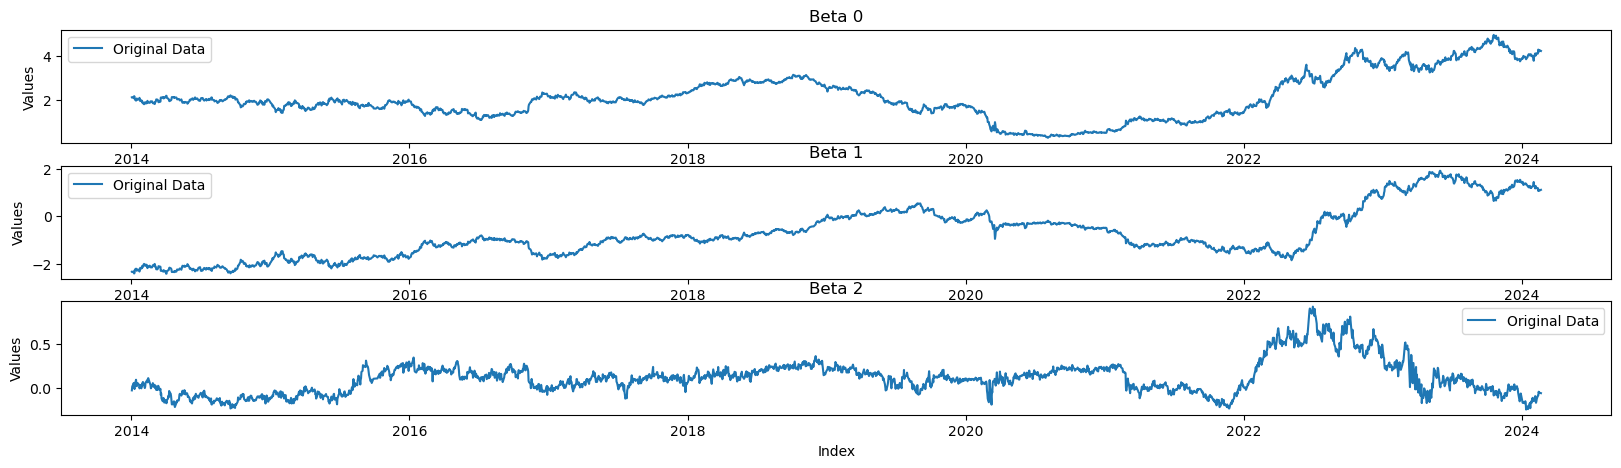

In [48]:


# Define the time range from the given start and end dates
#time_period


def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot, index=time_period)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    #moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    lambdas_series = pd.Series(list_plot, index=time_period)
    plt.subplot(3, 1, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    #plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')
    

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(fix_lambda_beta_0, 1, 'Beta 0')
plotting_param(fix_lambda_beta_1, 2, 'Beta 1')
plotting_param(fix_lambda_beta_2, 3, 'Beta 2')  # Assuming you have beta_3
#plotting_param(lambdas, 4, 'Lambda')  # Assuming you have beta_4
plt.show()

## Calibration for the lambda model

In [49]:
lambdas

[1.2776861232438654,
 1.2743907248426598,
 -1.5120429650250185e-05,
 -8.053034779743625e-06,
 1.2377160986385198,
 1.221682459580831,
 -9.454951489903341e-06,
 -8.22976502357095e-06,
 -9.129443362075955e-06,
 1.2405072818802227,
 1.2492281405829808,
 -1.5009467393748321e-05,
 1.2434265962272664,
 1.2181730250027392,
 1.243879502560331,
 1.2584248885583977,
 1.2589886529201917,
 -1.7058913475694844e-05,
 -1.742142176410552e-05,
 1.2588631409615323,
 -1.6596980796903456e-05,
 1.3029838136208434,
 1.3006789110762766,
 1.300760977269819,
 1.2962846172821918,
 1.330057004255618,
 1.3227605292244113,
 1.2963951022963547,
 1.2855803735992906,
 1.2953459106913292,
 1.2906137425292505,
 1.3052042628260567,
 1.3029725998020876,
 -1.0913824569606084e-05,
 -9.364696844689869e-06,
 -7.535795623554654e-06,
 -9.772254750758319e-06,
 -1.0327791760434982e-05,
 -1.1626670333344224e-05,
 -1.0354734633879285e-05,
 -1.0019019990073809e-05,
 -9.652593004369762e-06,
 -7.864945067690685e-06,
 -1.6096233633993

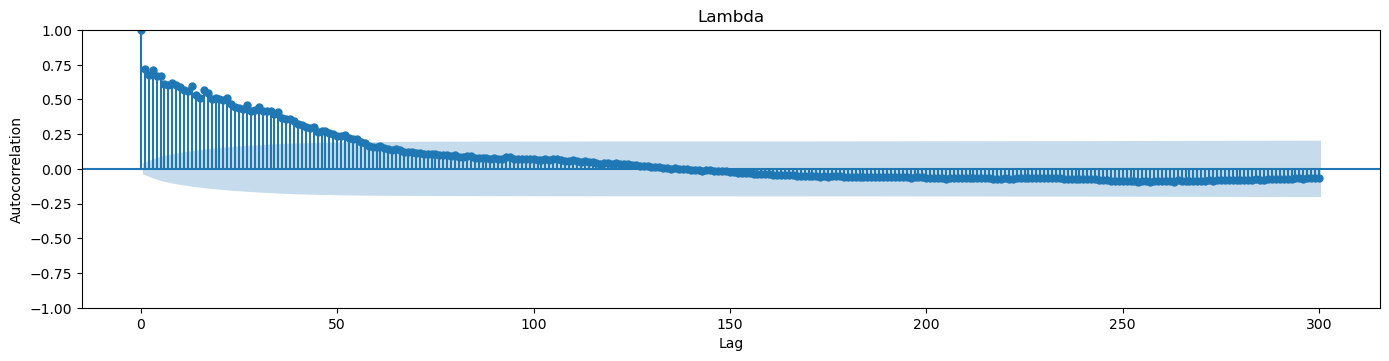

In [51]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(lambdas, 1, 'Lambda')
#plotting_auto_correlation(beta_2, 2, 'Beta 2')
#plotting_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

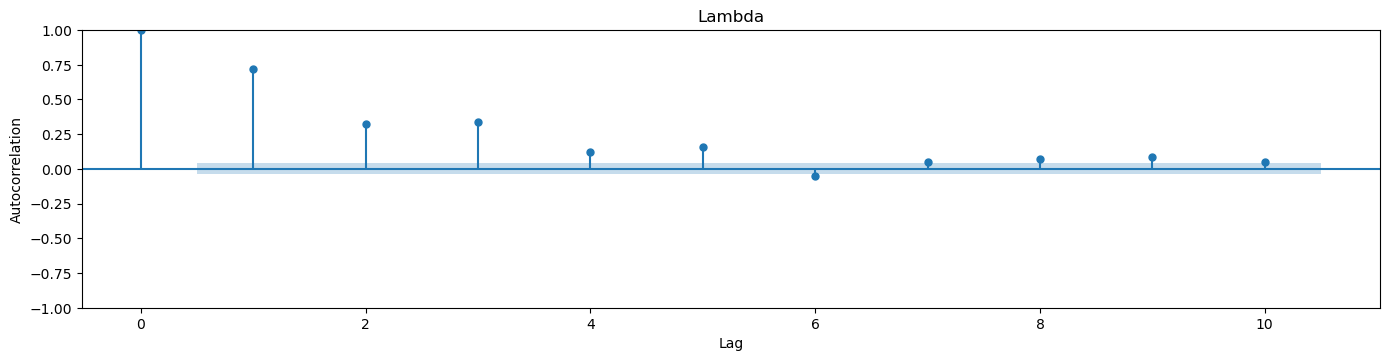

In [52]:
#Partial Auto Correlation
def plotting_partial_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_pacf(list_plot, lags=10, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_partial_auto_correlation(lambdas, 1, 'Lambda')
#plotting_partial_auto_correlation(beta_2, 2, 'Beta 2')
#plotting_partial_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Fine Tuning for the Arima Parameteres

In [61]:
model = pm.auto_arima(lambdas, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='bic')


 ARIMA(0,1,0)(0,0,0)[1] intercept   : BIC=11342.043, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : BIC=10364.181, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : BIC=10363.598, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : BIC=10355.513, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : BIC=10323.287, Time=0.29 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : BIC=10329.094, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : BIC=10863.323, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : BIC=10365.286, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : BIC=10316.560, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : BIC=10322.829, Time=0.38 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : BIC=10329.598, Time=0.66 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : BIC=10478.238, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : BIC=10358.239, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : BIC=10322.706, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : BIC=10330.463, Time=0.61

In [62]:
forecasts = []
for i in range(5,len(lambdas) - 1):
    initial_model = ARIMA(lambdas[:i], order=(1,1,2))  # Replace p, d, q with your model's parameters
    fitted_model = initial_model.fit()
    forecast = fitted_model.forecast(steps=1)
    forecasts.append(forecast[0])
    

/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/b

In [64]:
r2_score(forecasts, lambdas[6:])

0.3949246572955559

In [55]:
?pm.auto_arima

Signature:
pm.auto_arima(
    y,
    X=None,
    start_p=2,
    d=None,
    start_q=2,
    max_p=5,
    max_d=2,
    max_q=5,
    start_P=1,
    D=None,
    start_Q=1,
    max_P=2,
    max_D=1,
    max_Q=2,
    max_order=5,
    m=1,
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',
    stepwise=True,
    n_jobs=1,
    start_params=None,
    trend=None,
    method='lbfgs',
    maxiter=50,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action='trace',
    trace=False,
    random=False,
    random_state=None,
    n_fits=10,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring='mse',
    scoring_args=None,
    with_intercept='auto',
    sarimax_kwargs=None,
    **fit_args,
)
Docstring:
Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal
parameters for an ``ARIMA`` model, settling o

In [ ]:
best_aic = float('inf')
best_bic = float('inf')
combined_ic = float('inf')
aic_values = []
bic_values = []
combined_values = []
q_values = []

for q in tqdm(range(1, 50), desc='Fitting Models'):
    try:
        model = ARIMA(lambdas, order=(5, 0, q))
        model_fit = model.fit(maxiter=10000)
        aic_values.append(model_fit.aic)
        bic_values.append(model_fit.bic)
        combined_values.append((model_fit.aic + model_fit.bic) / 2)
        q_values.append(q)

        if model_fit.aic < best_aic:
            aic_res = model_fit.specification['order']
            best_aic = model_fit.aic

        if model_fit.bic < best_bic:
            bic_res = model_fit.specification['order']
            best_bic = model_fit.bic

        if (model_fit.bic + model_fit.aic) / 2 < combined_ic:
            combined_res = model_fit.specification['order']
            combined_ic = (model_fit.bic + model_fit.aic) / 2
    except Exception as e:
        print(f"An error occurred at q={q}: {e}")

# Plotting the AIC, BIC, and combined values
plt.figure(figsize=(10, 5))
plt.plot(q_values, aic_values, label='AIC', color='blue')
plt.plot(q_values, bic_values, label='BIC', color='red')
plt.plot(q_values, combined_values, label='Combined (AIC+BIC)/2', color='green')
plt.xlabel('q value')
plt.ylabel('Information Criterion')
plt.title('AIC, BIC, and Combined Values for Different q')
plt.legend()
plt.show()


# Checking statistical topics and applying various time series model for each parameter

(ii) Investigate the statistical properties of the time series of these pa- rameters. Do they show any mean reversion properties, can they be modeled by any of the time series models (such as ARIMA)?

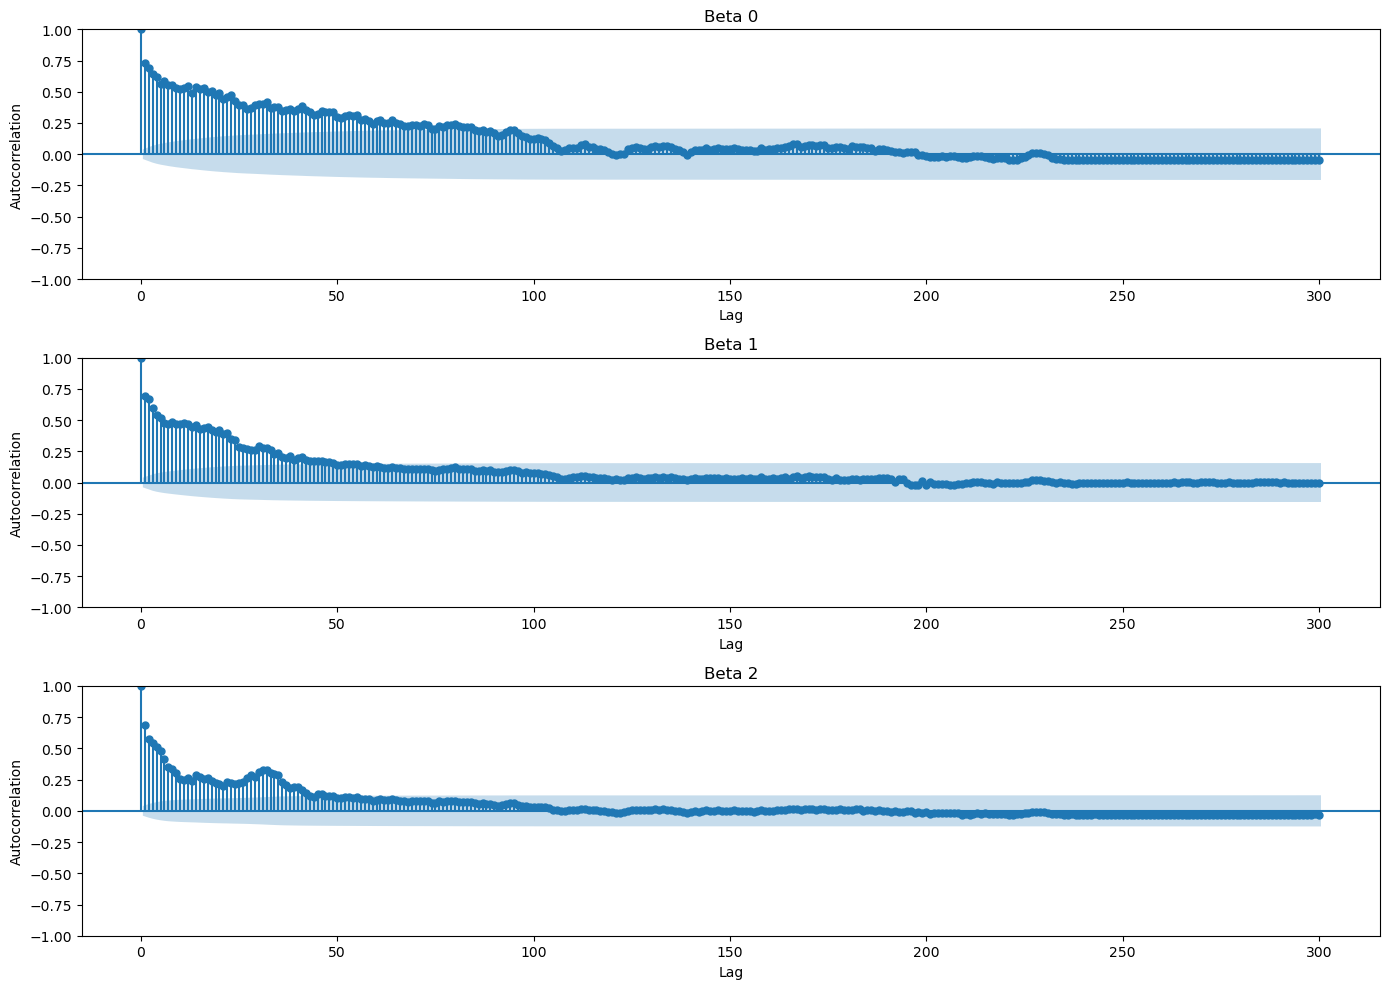

In [27]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(beta_0, 1, 'Beta 0')
plotting_auto_correlation(beta_1, 2, 'Beta 1')
plotting_auto_correlation(beta_2, 3, 'Beta 2')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

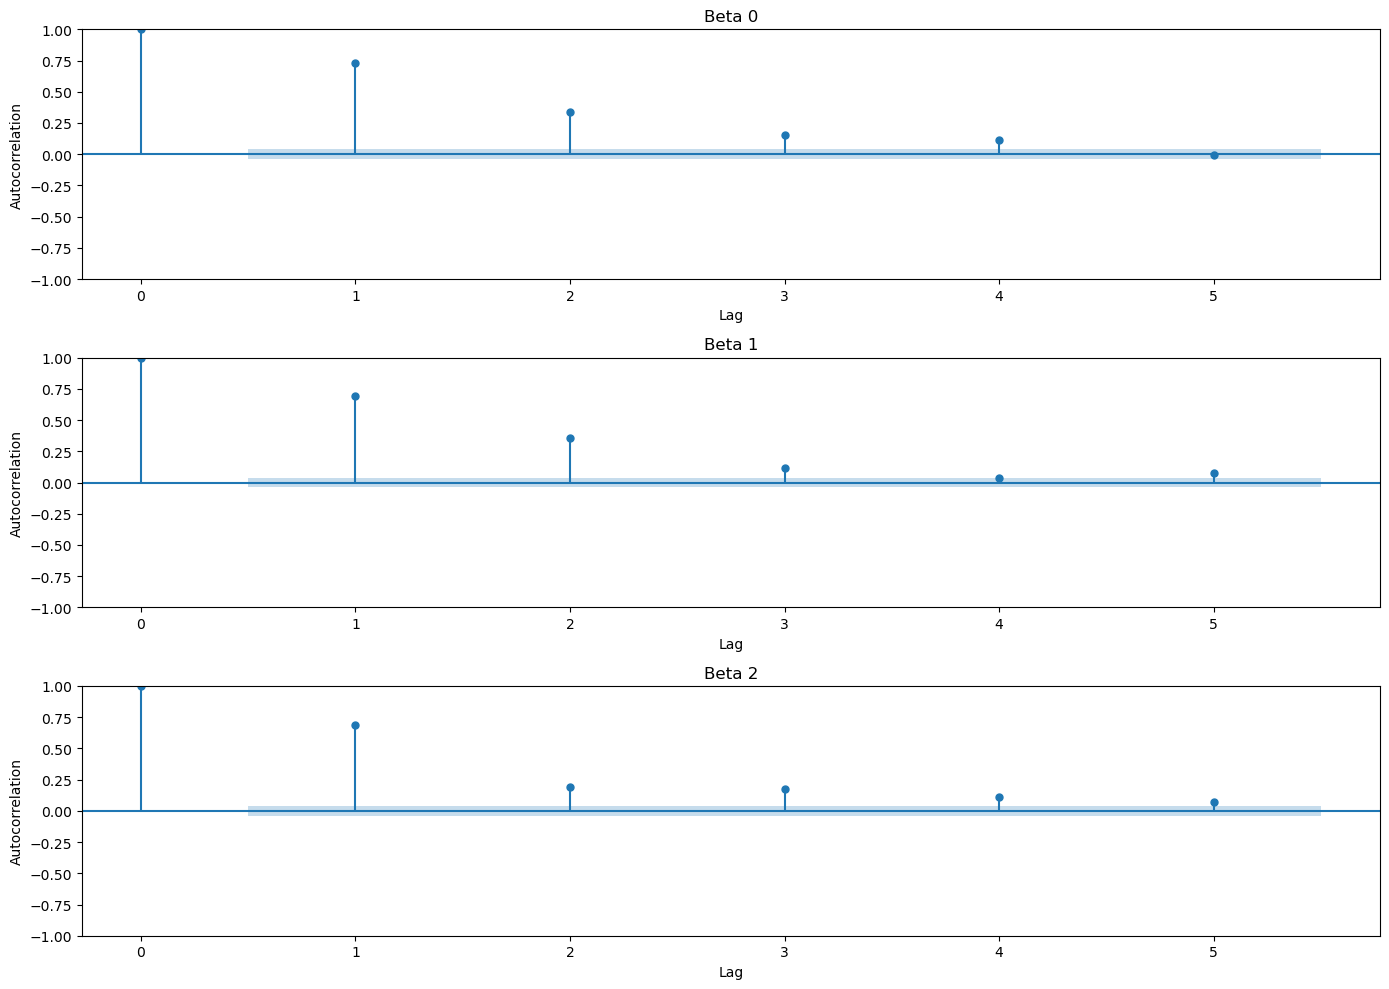

In [28]:
#Partial Auto Correlation
def plotting_partial_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_pacf(list_plot, lags=5, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_partial_auto_correlation(beta_0, 1, 'Beta 0')
plotting_partial_auto_correlation(beta_1, 2, 'Beta 1')
plotting_partial_auto_correlation(beta_2, 3, 'Beta 2')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [29]:

def check_mean_reversion(series, name):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("The series " + name + "is likely mean-reverting.")
    else:
        print("The series " + name + " is not likely mean-reverting.")

# Assume 'time_series' is your pandas Series
check_mean_reversion(beta_0, "beta 0")
check_mean_reversion(beta_1, "beta 1")
check_mean_reversion(beta_2, "beta 2")

ADF Statistic: -4.759696
p-value: 0.000065
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 0is likely mean-reverting.
ADF Statistic: -5.654179
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 1is likely mean-reverting.
ADF Statistic: -4.712317
p-value: 0.000080
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 2is likely mean-reverting.


# stationarity

In [30]:

# Assuming 'time_series' is your pandas Series
def check_stationarity(ts,name):
    # Perform Augmented Dickey-Fuller test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(ts, autolag='AIC')  # AIC is used to select the best lag length
    
    result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_test[4].items():
        result['Critical Value (%s)' % key] = value
        
    print(result)
    
    # Interpretation
    if result['p-value'] < 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

# Assume 'time_series' is your pandas Series
check_stationarity(beta_0, "beta 0")
check_stationarity(beta_1, "beta 1")
check_stationarity(beta_2, "beta 2")

Results of Augmented Dickey-Fuller Test:
Test Statistic                   -4.759696
p-value                           0.000065
#Lags Used                       27.000000
Number of Observations Used    2494.000000
Critical Value (1%)              -3.432975
Critical Value (5%)              -2.862700
Critical Value (10%)             -2.567387
dtype: float64
The series is likely stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                -5.654179e+00
p-value                        9.705912e-07
#Lags Used                     2.400000e+01
Number of Observations Used    2.497000e+03
Critical Value (1%)           -3.432972e+00
Critical Value (5%)           -2.862698e+00
Critical Value (10%)          -2.567387e+00
dtype: float64
The series is likely stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -4.712317
p-value                           0.000080
#Lags Used                       27.000000
Number of Observations Used    2494.000000


# Optimal Beta 0 Model

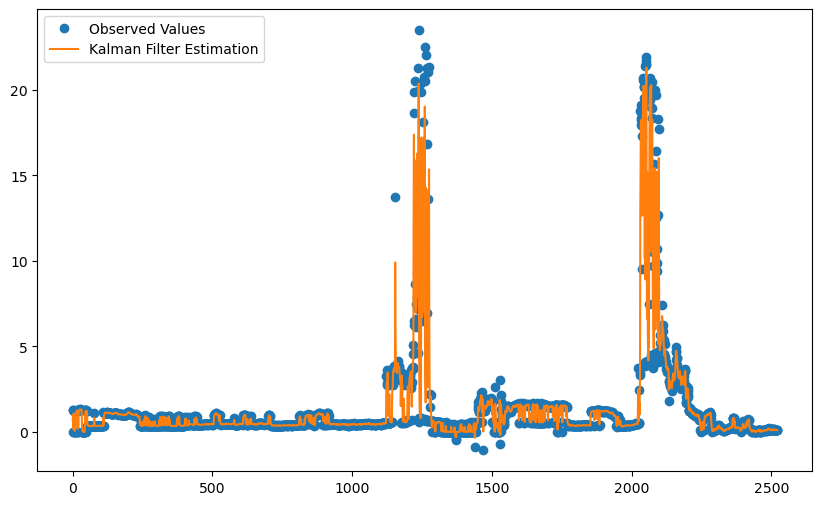

Next value prediction: 0.10283523409594805


0.4946521808603733

In [80]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Estimate the hidden states
state_means, state_covariances = kf.filter(lambdas)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(lambdas, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], lambdas[1:])

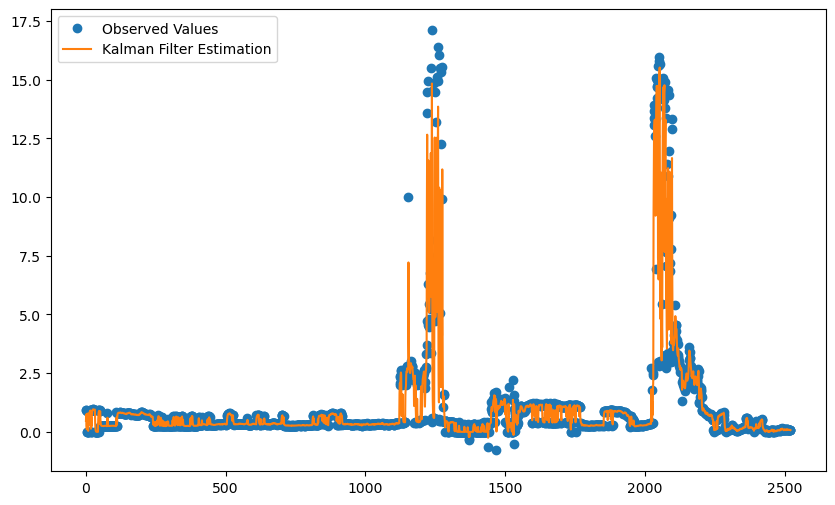

Next value prediction: 0.07490151243799617


0.4946521808603732

In [88]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = lambdas/np.mean(lambdas)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

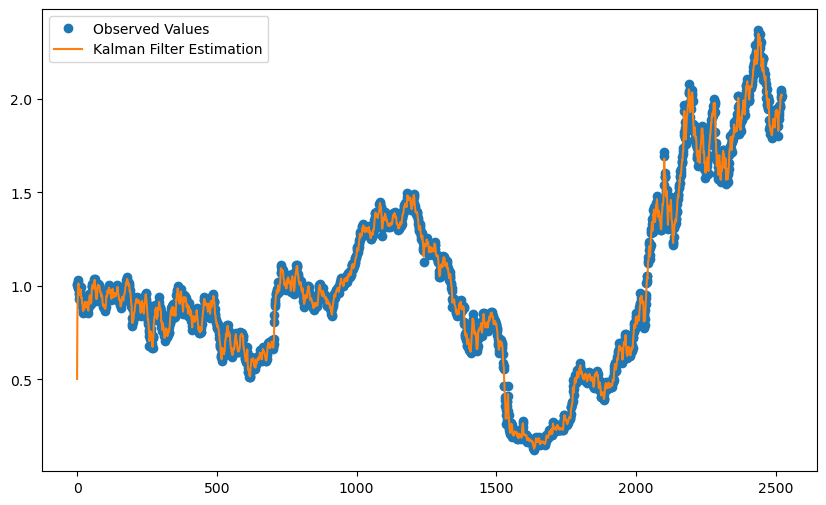

Next value prediction: 2.0194699732282326


0.9959022281879844

In [86]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_0/np.mean(beta_0)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

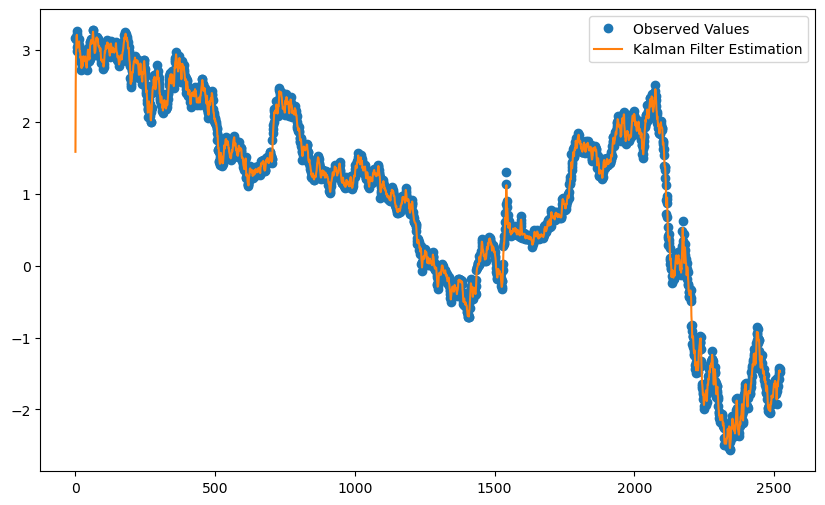

Next value prediction: -1.4745172998108036


0.9965204285858472

In [87]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_1/np.mean(beta_1)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

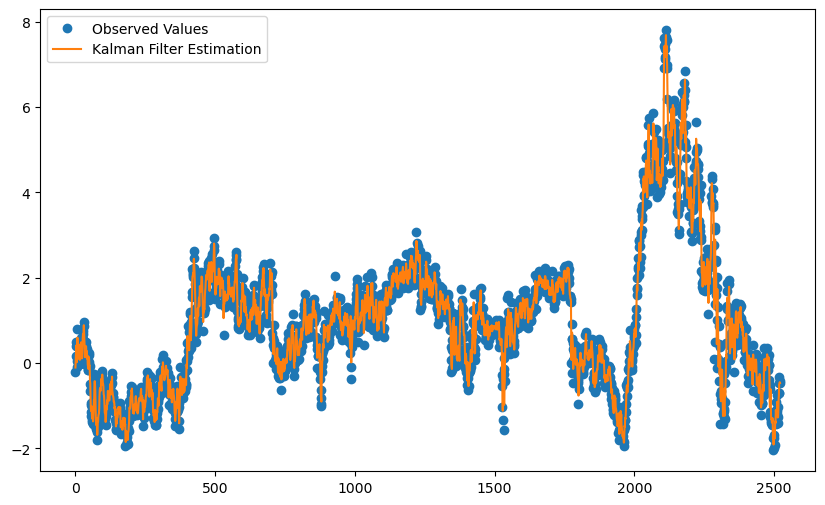

Next value prediction: -0.46415533290424327


0.9568864925336836

In [85]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_2/np.mean(beta_2)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

In [71]:
r2_score(state_means[:-1], lambdas[1:])

0.4946521808603733

In [77]:
# It seems I forgot to import numpy before using it. Let's correct that and run the function again.

import numpy as np

def moving_average_with_lag(observations, window_size=5, lag=5):
    """
    Compute the moving average of an array with a specified lag.
    
    Parameters:
    - observations: The input array of observations.
    - window_size: The size of the moving average window.
    - lag: The lag to apply after computing the moving average.
    
    Returns:
    - A numpy array containing the moving averages with the specified lag.
    """
    
    # Compute the moving average
    moving_averages = np.convolve(observations, np.ones(window_size) / window_size, mode='valid')
    
    # Apply the lag
    # Prepend np.nan (or zeros) to the start of the moving averages array to introduce the lag
    lagged_moving_averages = np.concatenate((np.full(lag, np.nan), moving_averages))
    
    # If the lag causes the result to be longer than the original, trim the excess
    if len(lagged_moving_averages) > len(observations):
        lagged_moving_averages = lagged_moving_averages[:len(observations)]
    
    return lagged_moving_averages

n = 3

# Example usage:
observations = lambdas
moving_average_with_lag_result = moving_average_with_lag(observations,n,n)

moving_average_with_lag_result
r2_score(moving_average_with_lag_result[n:], lambdas[n:])

0.5048491511019102

<Axes: >

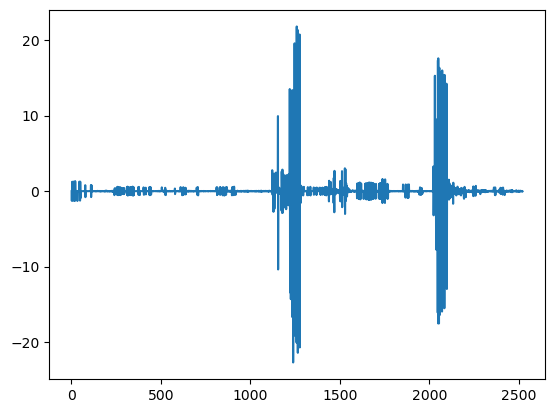

In [79]:
sample_series = pd.Series(lambdas)
sample_series.diff(1).plot()

In [66]:
r2_score(moving_average_with_lag_result[5:], lambdas[5:])

0.4453901321419629

In [39]:

# Assume 'time_series' is your non-stationary pandas Series
# Step 1: Difference the data to make it stationary (determined by ADF test and visual inspection)
# Let's assume we found d=1 is sufficient for stationarity

# Step 2: Determine p and q using ACF and PACF plots (not shown here)
#p and q
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for d in [1,2,3]:
    for q in range(18,23):
        # Step 3: Fit the ARIMA model
        model = ARIMA(beta_0, order=(2, d, q))  # using d=1 as found in step 1
        model_fit = model.fit()
        #model_fit.specification['order']
        if model_fit.aic < best_aic:
            aic_res =  model_fit.specification['order']
            best_aic = model_fit.aic
            
        if model_fit.bic < best_bic:
            bic_res =  model_fit.specification['order']
            best_bix = model_fit.bic
        
        if model_fit.bic + model_fit.aic < combined_bic:
            combined_res =  model_fit.specification['order']
            combined_bic = model_fit.bic + model_fit.aic
            


/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In [ ]:
print(bic_res)
print(aic_res)
print(combined_res)

In [ ]:
model = ARIMA(beta_1, order=(2, 1, 19), maxiter=500, method='lbfgs')
model_fit = model.fit()

# Check the summary
print(model_fit.summary())

# Optimal Beta 1

In [ ]:


# Assume 'time_series' is your non-stationary pandas Series
# Step 1: Difference the data to make it stationary (determined by ADF test and visual inspection)
# Let's assume we found d=1 is sufficient for stationarity

# Step 2: Determine p and q using ACF and PACF plots (not shown here)
#p and q
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for d in [1,2,3]:
    for q in range(1,15):
        # Step 3: Fit the ARIMA model
        model = ARIMA(beta_1, order=(2, d, q))  # using d=1 as found in step 1
        model_fit = model.fit()
        #model_fit.specification['order']
        if model_fit.aic < best_aic:
            aic_res =  model_fit.specification['order']
            best_aic = model_fit.aic
            
        if model_fit.bic < best_bic:
            bic_res =  model_fit.specification['order']
            best_bix = model_fit.bic
        
        if model_fit.bic + model_fit.aic < combined_bic:
            combined_res =  model_fit.specification['order']
            combined_bic = model_fit.bic + model_fit.aic
            


In [ ]:
combined_res

In [ ]:

model = ARIMA(beta_2, order=(2, 2, 1))  # using d=1 as found in step 1
model_fit = model.fit()
print(model_fit.summary())

# Find the optimal Parameters for Beta 1 for GARCH, FAILING so far

In [ ]:


            
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for q in range(5,25):
    # Specifying a GARCH(1, 1) model
    garch_model = arch_model(beta_1, vol='Garch', p=2, q=q)

    # Fit the model
    garch_fit = garch_model.fit(disp='off')  # disp='off' turns off the convergence output
    if garch_fit.aic < best_aic:
        aic_res =   [2,q]
        best_aic = garch_fit.aic
            
    if garch_fit.bic < best_bic:
        bic_res =  [2,q]
        best_bix = garch_fit.bic
    
    if garch_fit.bic + garch_fit.aic < combined_bic:
        combined_res =   [2,q]
        combined_bic = garch_fit.bic + garch_fit.aic


In [ ]:
print(aic_res)
print(bic_res)
print(combined_res)

In [ ]:

# Specifying a GARCH(1, 1) model
garch_model = arch_model(beta_2, vol='Garch', p=2, q=9)

# Fit the model
garch_model.fit(update_freq=5, disp='off', show_warning=True, tol=1e-6)
print(garch_fit.summary())


## Garch Model not converging

(iii) Can the yield predictions based on the time series properties of the parameters be used for profitable trading?

In [ ]:
# We need to implement a backtest here with the functions we calibrated and include train test split.

In [ ]:
# Assuming 'merged_df' is your DataFrame and it's already sorted by date
total_rows = len(merged_df)
last_20_percent_index = int(total_rows * 0.789)  # Calculate the starting index for the last 20%

# Select the last 20% of the data
backtest = merged_df.iloc[last_20_percent_index:]

backtest

In [ ]:
backtest

In [ ]:
backtest['lambda']=-1.08


In [ ]:
results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(backtest)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(NS_model, x_data, y_data,maxfev=10000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = NS_model(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    results[row] = {
        'Parameters': params,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

(iv) Develop an ML based (using xgboost, or neural net based) frame- work of analysis of the parameters leading to a profitable strategy?

(v) Can the yield predictions based on the ML approach lead to prof- itable trading?